# Importing The Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                           roc_curve, auc, classification_report, roc_auc_score)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Loading The Dataset

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

In [3]:
print("Dataset Information:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {len(feature_names)}")
print(f"Target names: {target_names}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Malignant (0): {np.sum(y == 0)}, Benign (1): {np.sum(y == 1)}")

Dataset Information:
Features shape: (569, 30)
Target shape: (569,)
Feature names: 30
Target names: ['malignant' 'benign']
Class distribution: [212 357]
Malignant (0): 212, Benign (1): 357


# Preparing + Splitting The Data

In [4]:
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")


Train set size: 455
Test set size: 114
Train set class distribution: [170 285]
Test set class distribution: [42 72]


# Exploratory Data Analysis

Basic Statistics of Features

In [7]:
print(df.describe().T)

                         count        mean         std         min  \
mean radius              569.0   14.127292    3.524049    6.981000   
mean texture             569.0   19.289649    4.301036    9.710000   
mean perimeter           569.0   91.969033   24.298981   43.790000   
mean area                569.0  654.889104  351.914129  143.500000   
mean smoothness          569.0    0.096360    0.014064    0.052630   
mean compactness         569.0    0.104341    0.052813    0.019380   
mean concavity           569.0    0.088799    0.079720    0.000000   
mean concave points      569.0    0.048919    0.038803    0.000000   
mean symmetry            569.0    0.181162    0.027414    0.106000   
mean fractal dimension   569.0    0.062798    0.007060    0.049960   
radius error             569.0    0.405172    0.277313    0.111500   
texture error            569.0    1.216853    0.551648    0.360200   
perimeter error          569.0    2.866059    2.021855    0.757000   
area error          

Correlation Heatmap

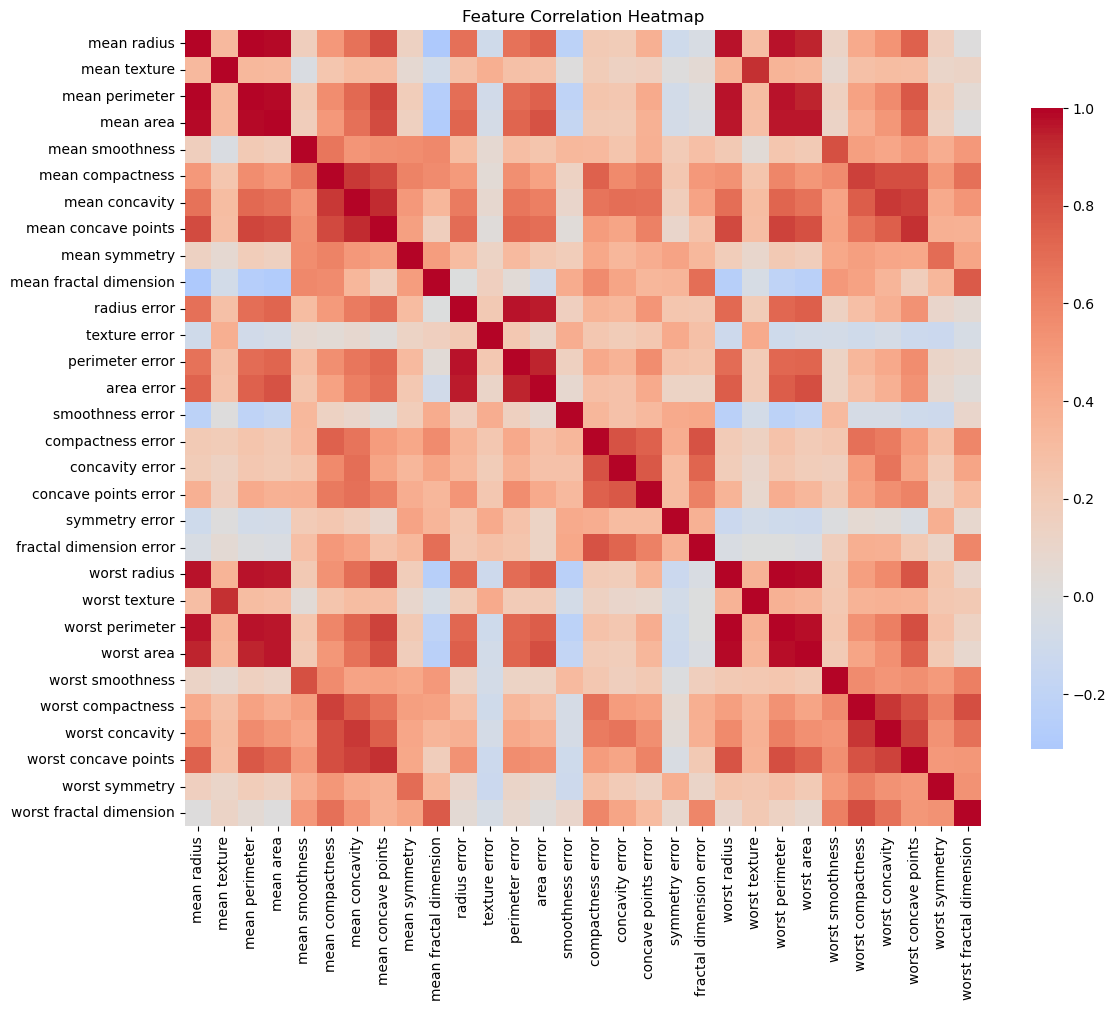

In [8]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.iloc[:, :-2].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

Examining Labels Distribution

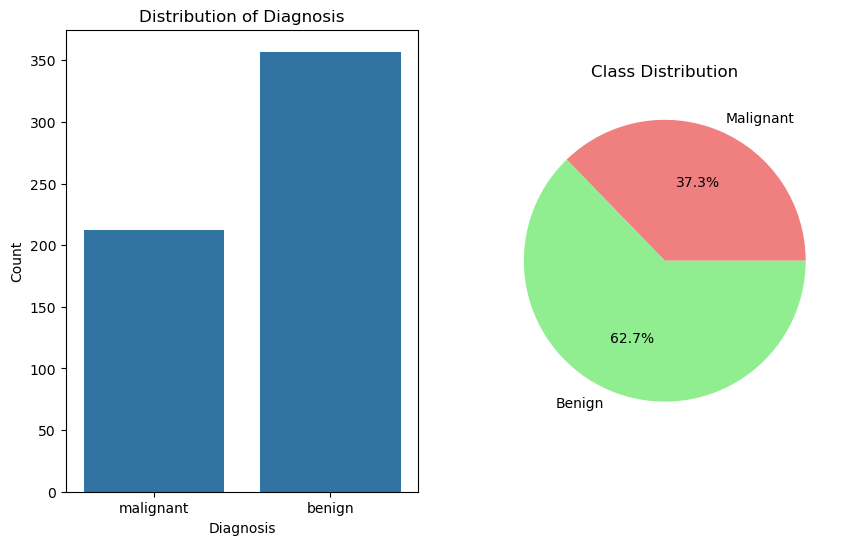

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie([np.sum(y == 0), np.sum(y == 1)],
        labels=['Malignant', 'Benign'],
        autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Class Distribution')
plt.show()

Feature Distributions by Class

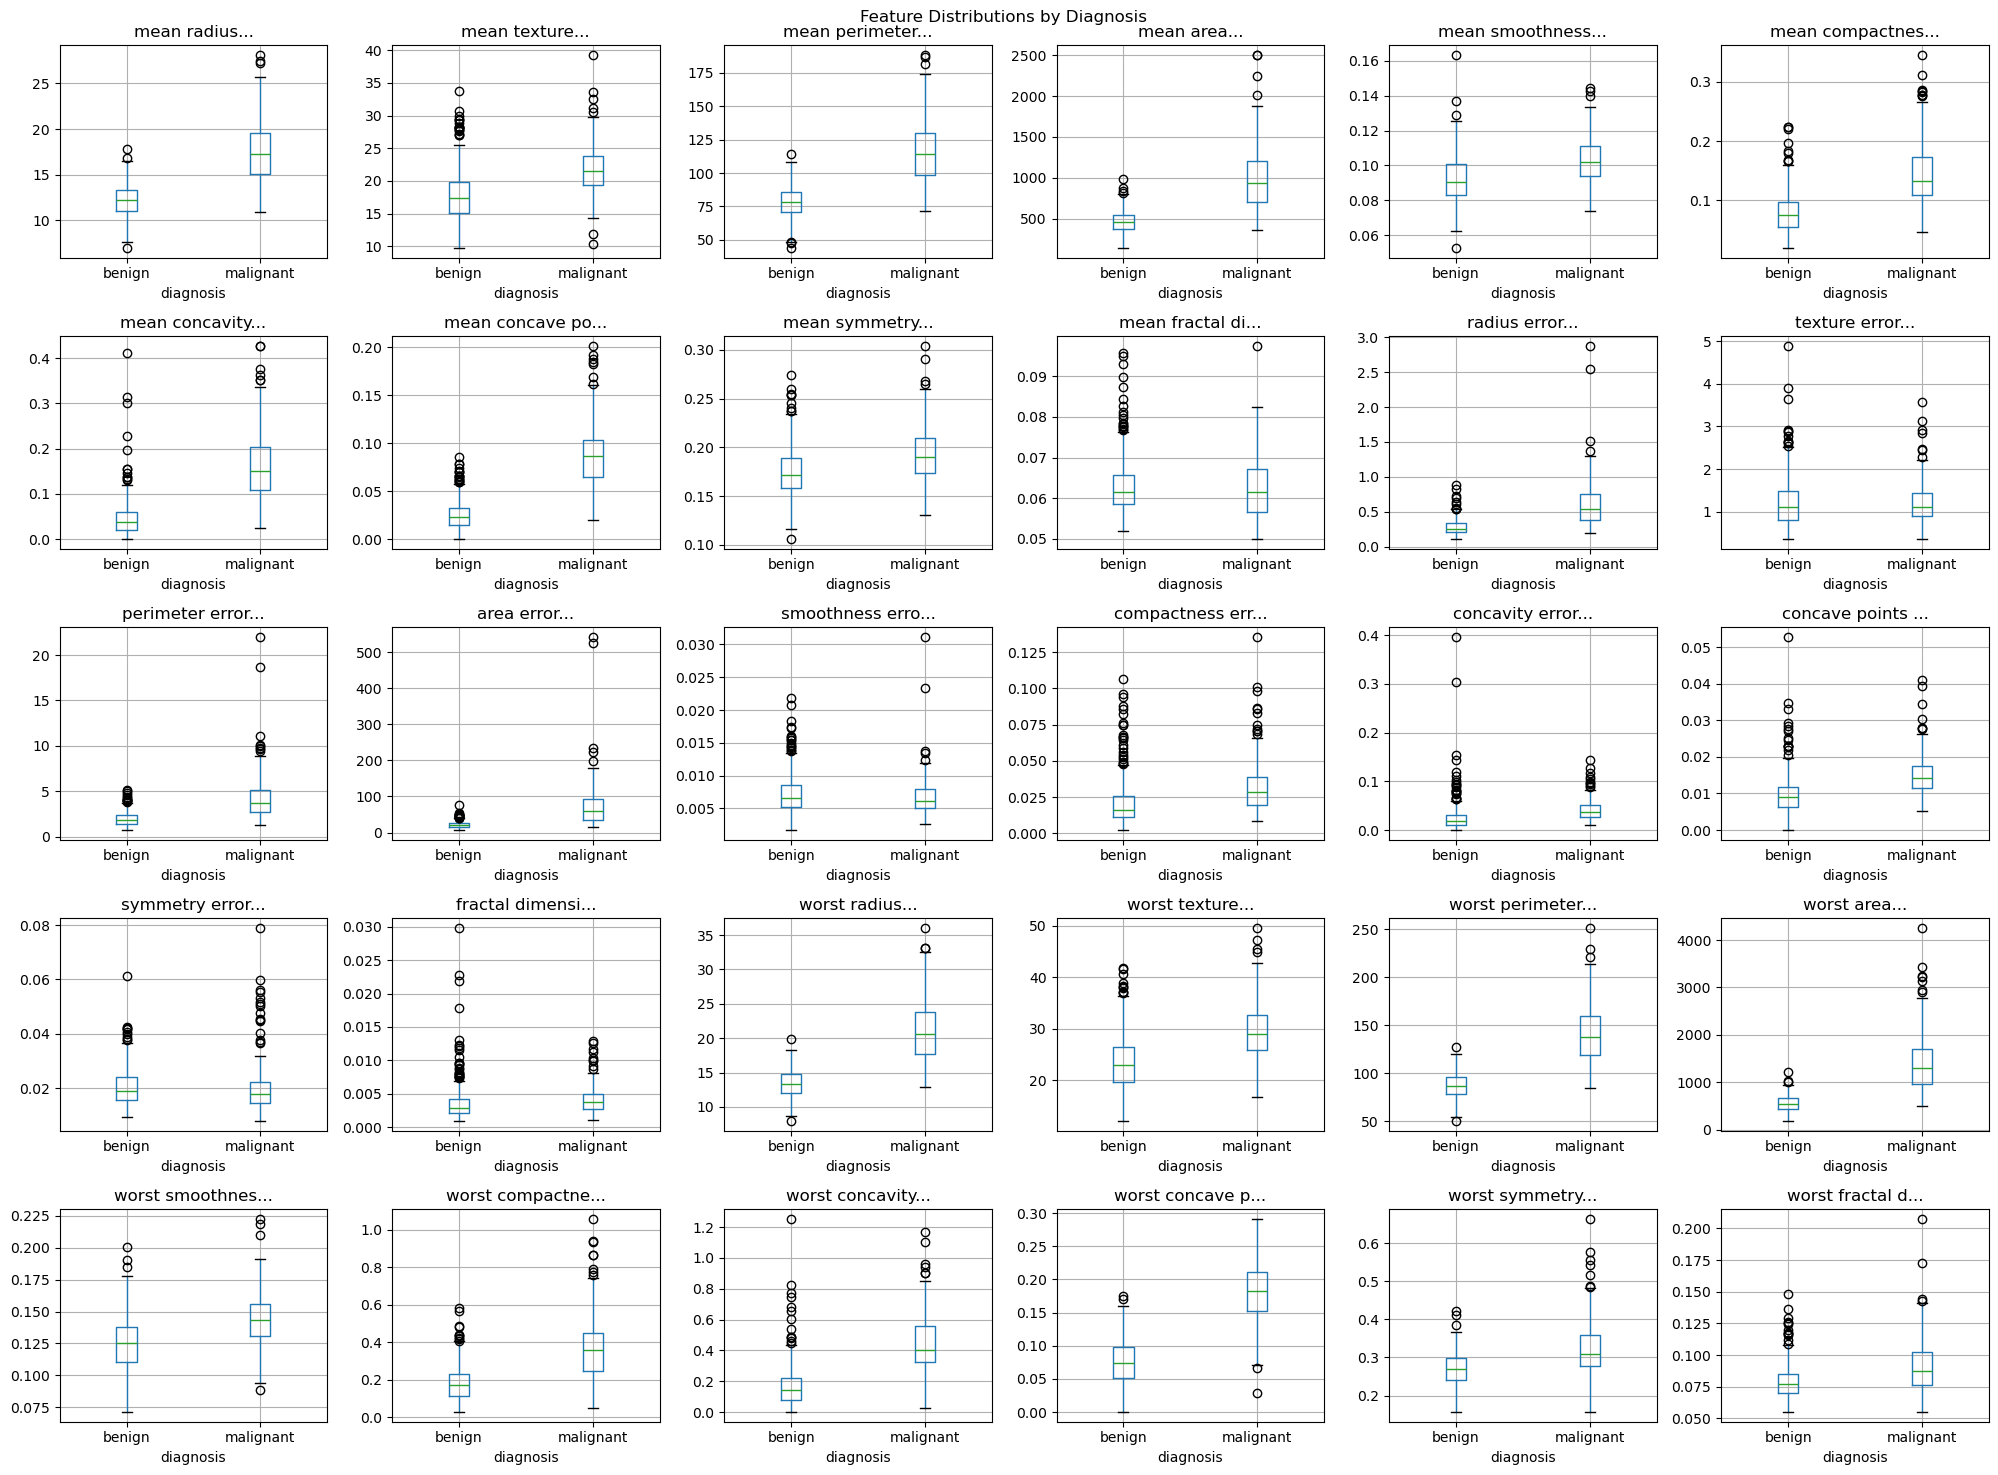

In [10]:
fig, axes = plt.subplots(5, 6, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(feature_names[:30]):
    df.boxplot(column=feature, by='diagnosis', ax=axes[i])
    axes[i].set_title(f'{feature[:15]}...')

plt.suptitle('Feature Distributions by Diagnosis')
plt.tight_layout()
plt.show()

Checking for Missing Values

In [11]:
print(f"\nMissing values in dataset: {df.isnull().sum().sum()}")


Missing values in dataset: 0


Feature Scaling Visualization

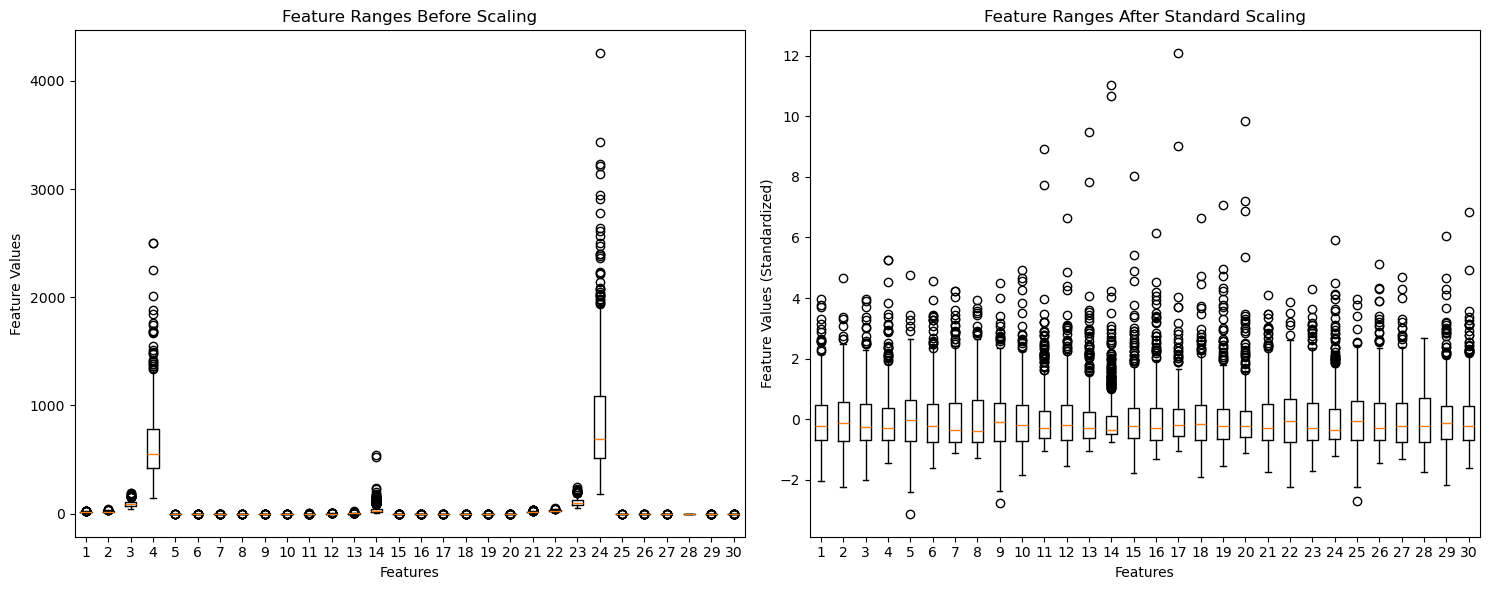

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].boxplot(X)
axes[0].set_title('Feature Ranges Before Scaling')
axes[0].set_ylabel('Feature Values')
axes[0].set_xlabel('Features')

axes[1].boxplot(X_scaled)
axes[1].set_title('Feature Ranges After Standard Scaling')
axes[1].set_ylabel('Feature Values (Standardized)')
axes[1].set_xlabel('Features')

plt.tight_layout()
plt.show()

# Model Training

In [13]:
models = {}
results = {}

Simple Logistic Regression with Default Adjustments

In [14]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
models['Default_LR'] = model

Logistic Regression with Feature Normalization

In [15]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])
model.fit(X_train, y_train)
models['Scaled_LR'] = model

Logistic Regression with Different C Values

In [16]:
C_values = [0.01, 0.1, 1, 10, 100]
best_c_score = 0
best_c_value = 1

for C_val in C_values:
    model_temp = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=C_val, random_state=42))
    ])
    cv_scores = cross_val_score(model_temp, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(cv_scores)
    print(f"C={C_val}: Cross-val Accuracy = {mean_score:.4f}")

    if mean_score > best_c_score:
        best_c_score = mean_score
        best_c_value = C_val

C=0.01: Cross-val Accuracy = 0.9516
C=0.1: Cross-val Accuracy = 0.9802
C=1: Cross-val Accuracy = 0.9802
C=10: Cross-val Accuracy = 0.9692
C=100: Cross-val Accuracy = 0.9560


In [17]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=best_c_value, random_state=42))
])
model.fit(X_train, y_train)
models[f'LR_C_{best_c_value}'] = model
print(f"Best C value: {best_c_value}")

Best C value: 0.1


Logistic Regression with L1 Penalty

Note: We must choose an algorithm to use in optimization problem. Default solver is 'lbfgs', but 'lbfgs' is inconsistent with l1-penalty.

In [18]:
try:
    model = LogisticRegression(penalty='l1')
    model.fit(X_train, y_train)
except Exception as e:
    print(f"Error: {e}")

Error: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.


'liblinear' and 'saga' are consistent with l1-penalty. Therefore, we use 'liblinear' solver instead of 'lbfgs'.

In [19]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])
model.fit(X_train, y_train)
models['L1_LR'] = model

Logistic Regression with L2 Penalty

In [20]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', random_state=42))
])
model.fit(X_train, y_train)
models['L2_LR'] = model

Logistic Regression with Different Solvers

In [21]:
solvers_to_test = ['liblinear', 'lbfgs', 'saga']

for solver in solvers_to_test:
    try:
        if solver == 'liblinear':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(solver=solver, random_state=42))
            ])
        else:
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(solver=solver, max_iter=1000, random_state=42))
            ])

        model.fit(X_train, y_train)
        models[f'LR_{solver}'] = model

    except Exception as e:
        print(f"Failed to train with {solver}: {e}")

# Model Evaluation and Comparison

In [22]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [23]:
for name, model in models.items():
    results[name] = evaluate_model(model, X_test, y_test, name)

In [24]:
summary_df = pd.DataFrame({
    'Model': [results[name]['model_name'] for name in results],
    'Accuracy': [results[name]['accuracy'] for name in results],
    'F1-Score': [results[name]['f1_score'] for name in results],
    'ROC-AUC': [results[name]['roc_auc'] for name in results]
}).round(4)

print(summary_df.to_string(index=False))

       Model  Accuracy  F1-Score  ROC-AUC
  Default_LR    0.9649    0.9722   0.9954
   Scaled_LR    0.9825    0.9861   0.9954
    LR_C_0.1    0.9737    0.9793   0.9957
       L1_LR    0.9912    0.9931   0.9967
       L2_LR    0.9825    0.9861   0.9954
LR_liblinear    0.9825    0.9861   0.9957
    LR_lbfgs    0.9825    0.9861   0.9954
     LR_saga    0.9825    0.9861   0.9954


In [25]:
best_model_name = summary_df.loc[summary_df['Accuracy'].idxmax(), 'Model']
best_result = results[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_result['accuracy']:.4f}")
print(f"Best F1-Score: {best_result['f1_score']:.4f}")
print(f"Best ROC-AUC: {best_result['roc_auc']:.4f}")


Best Model: L1_LR
Best Accuracy: 0.9912
Best F1-Score: 0.9931
Best ROC-AUC: 0.9967


# Visualization of Results

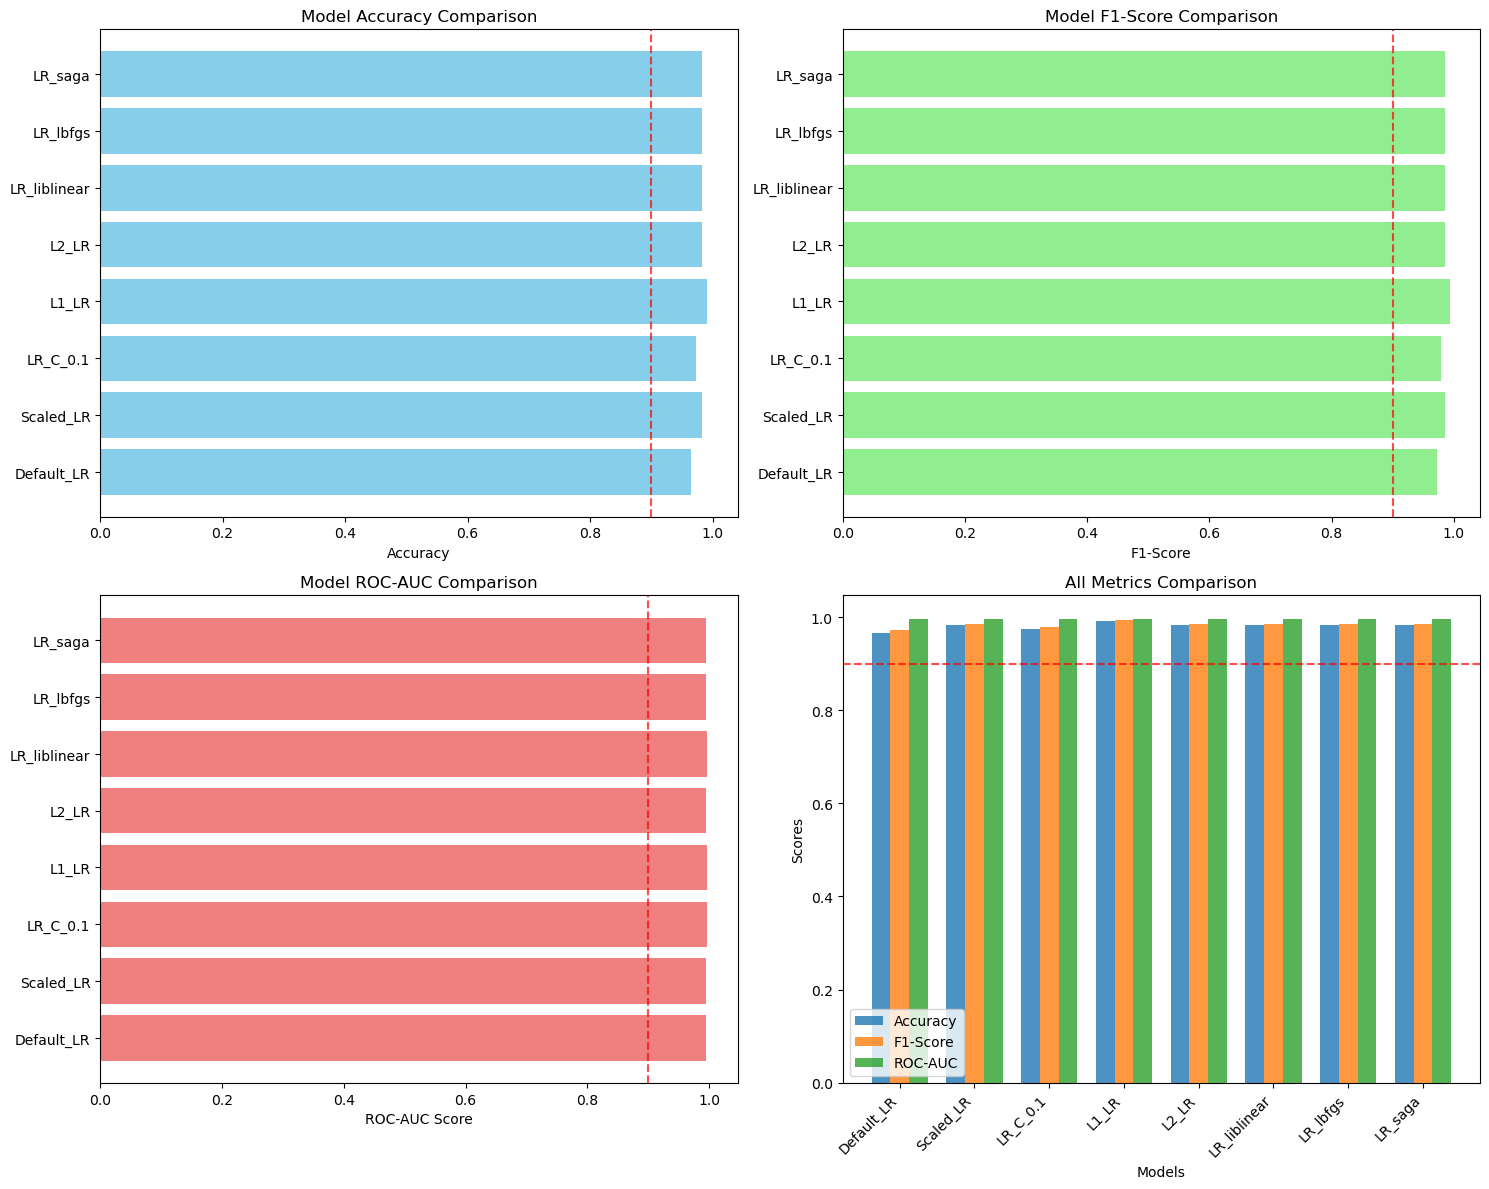

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
models_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in models_names]
axes[0,0].barh(models_names, accuracies, color='skyblue')
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].set_xlabel('Accuracy')
axes[0,0].axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='90% Baseline')

# F1-Score
f1_scores = [results[name]['f1_score'] for name in models_names]
axes[0,1].barh(models_names, f1_scores, color='lightgreen')
axes[0,1].set_title('Model F1-Score Comparison')
axes[0,1].set_xlabel('F1-Score')
axes[0,1].axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='90% Baseline')

# ROC-AUC
roc_aucs = [results[name]['roc_auc'] for name in models_names]
axes[1,0].barh(models_names, roc_aucs, color='lightcoral')
axes[1,0].set_title('Model ROC-AUC Comparison')
axes[1,0].set_xlabel('ROC-AUC Score')
axes[1,0].axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='90% Baseline')

# All metrics together
x_pos = np.arange(len(models_names))
width = 0.25
axes[1,1].bar(x_pos - width, accuracies, width, label='Accuracy', alpha=0.8)
axes[1,1].bar(x_pos, f1_scores, width, label='F1-Score', alpha=0.8)
axes[1,1].bar(x_pos + width, roc_aucs, width, label='ROC-AUC', alpha=0.8)
axes[1,1].set_title('All Metrics Comparison')
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('Scores')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(models_names, rotation=45, ha='right')
axes[1,1].legend()
axes[1,1].axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='90% Baseline')

plt.tight_layout()
plt.show()

# ROC Curves

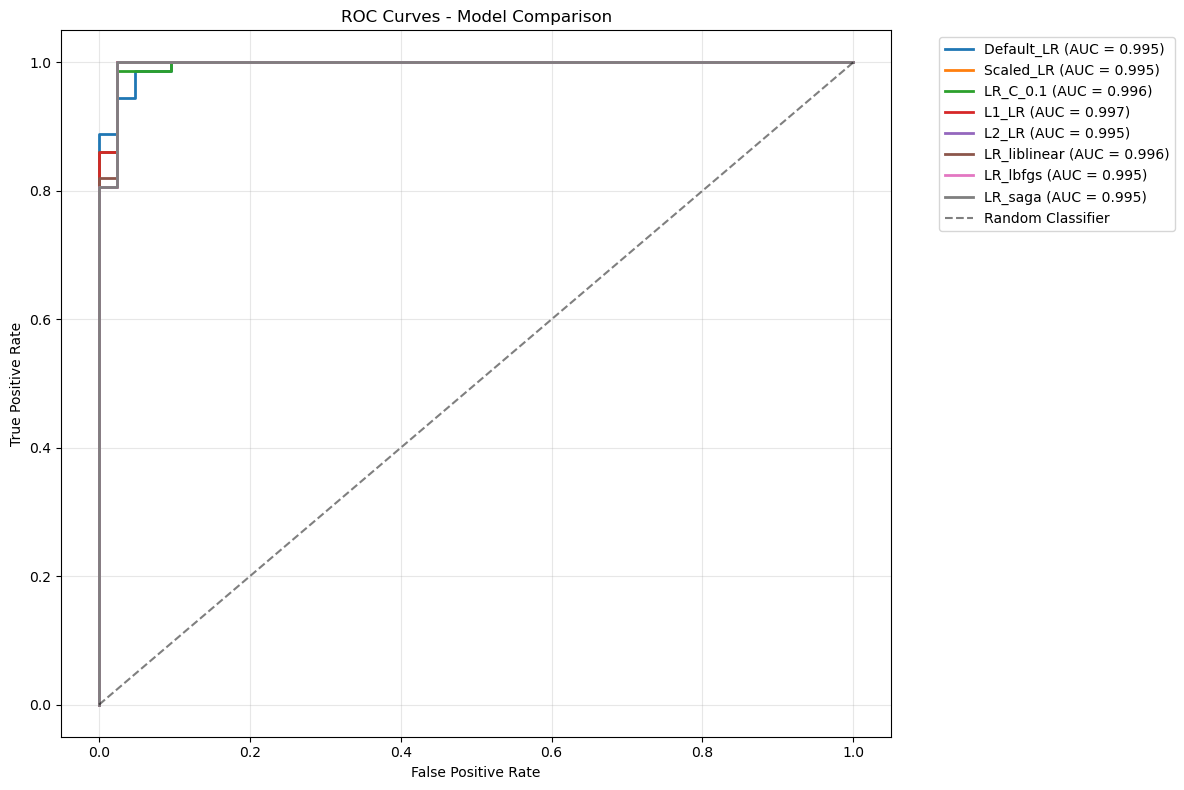

In [27]:
plt.figure(figsize=(12, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'],
             label=f'{name} (AUC = {result["roc_auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrices

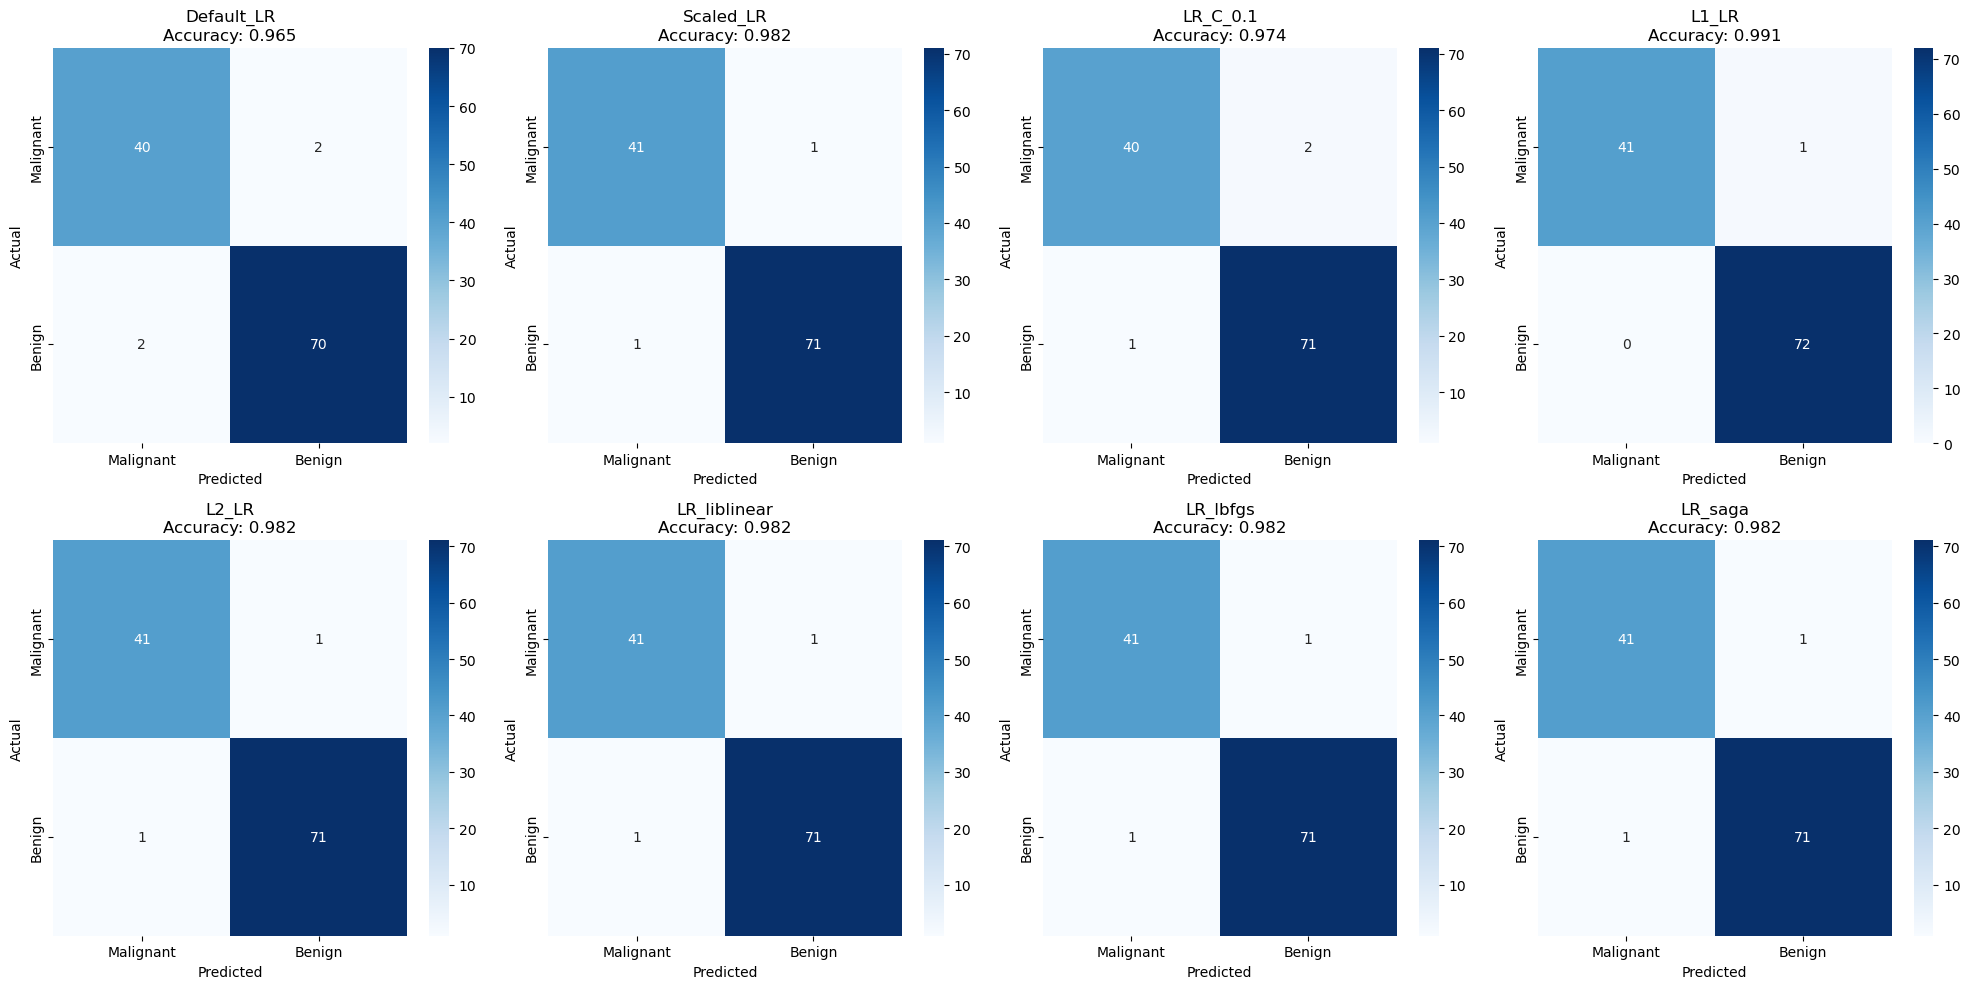

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide empty subplots
for idx in range(len(results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Detailed Classification Report for Best Model

In [29]:
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best,
                          target_names=['Malignant', 'Benign']))

              precision    recall  f1-score   support

   Malignant       1.00      0.98      0.99        42
      Benign       0.99      1.00      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



# Feature Importance for The Best Model

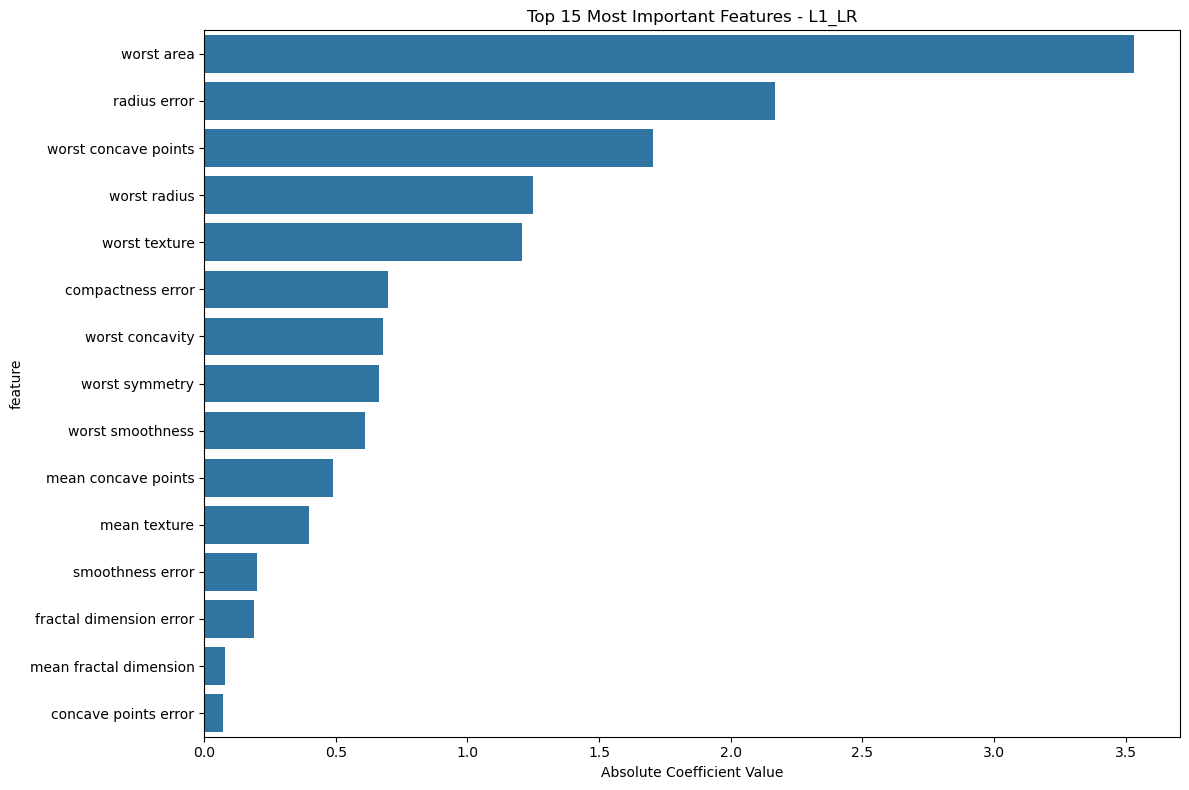

In [30]:
if hasattr(best_model.named_steps.get('lr', best_model), 'coef_'):
    if hasattr(best_model, 'named_steps'):
        coefficients = best_model.named_steps['lr'].coef_[0]
    else:
        coefficients = best_model.coef_[0]

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': abs(coefficients)
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title(f'Top 15 Most Important Features - {best_model_name}')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()

# Final Summary and Analysis

In [31]:
print(f"   - Total samples: {X.shape[0]}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Class distribution: {np.bincount(y)}")
print(f"   - Malignant/Benign ratio: {np.sum(y==0)/len(y):.2%}/{np.sum(y==1)/len(y):.2%}")

   - Total samples: 569
   - Features: 30
   - Class distribution: [212 357]
   - Malignant/Benign ratio: 37.26%/62.74%


In [32]:
accuracy_rank = summary_df.sort_values('Accuracy', ascending=False)
print("\n  Ranking By Accuracy:")
for i, (_, row) in enumerate(accuracy_rank.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['Accuracy']:.4f}")


  Ranking By Accuracy:
   1. L1_LR: 0.9912
   2. Scaled_LR: 0.9825
   3. L2_LR: 0.9825
   4. LR_liblinear: 0.9825
   5. LR_lbfgs: 0.9825
   6. LR_saga: 0.9825
   7. LR_C_0.1: 0.9737
   8. Default_LR: 0.9649


In [33]:
f1_rank = summary_df.sort_values('F1-Score', ascending=False)
print("\n  Ranking By F1-Score:")
for i, (_, row) in enumerate(f1_rank.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['F1-Score']:.4f}")


  Ranking By F1-Score:
   1. L1_LR: 0.9931
   2. Scaled_LR: 0.9861
   3. L2_LR: 0.9861
   4. LR_liblinear: 0.9861
   5. LR_lbfgs: 0.9861
   6. LR_saga: 0.9861
   7. LR_C_0.1: 0.9793
   8. Default_LR: 0.9722


In [34]:
auc_rank = summary_df.sort_values('ROC-AUC', ascending=False)
print("\n  Ranking By ROC-AUC:")
for i, (_, row) in enumerate(auc_rank.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['ROC-AUC']:.4f}")


  Ranking By ROC-AUC:
   1. L1_LR: 0.9967
   2. LR_C_0.1: 0.9957
   3. LR_liblinear: 0.9957
   4. Default_LR: 0.9954
   5. Scaled_LR: 0.9954
   6. L2_LR: 0.9954
   7. LR_lbfgs: 0.9954
   8. LR_saga: 0.9954


In [35]:
print(f"   - Best overall model: {best_model_name}")
print(f"   - Impact of feature scaling: {(results['Scaled_LR']['accuracy'] - results['Default_LR']['accuracy']):.4f}")
print(f"   - L1 vs L2 penalty difference: {(results['L1_LR']['accuracy'] - results['L2_LR']['accuracy']):.4f}")
print(f"   - Recommended model for deployment: {best_model_name}")

   - Best overall model: L1_LR
   - Impact of feature scaling: 0.0175
   - L1 vs L2 penalty difference: 0.0088
   - Recommended model for deployment: L1_LR
